In [ ]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('.'), '..')))

%load_ext autoreload
%autoreload 2
from analyzer import *

MAIN_DIR = "YOLOKey/"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Import data
data, models = import_data(MAIN_DIR)

print(list(data['YOLOMax'].keys()))


21
YOLOKey/YOLOMax/weights/best_epoch_21.pt
Building YOLOv9 Base model with 45 classes
36
YOLOKey/YOLODrop/weights/best_epoch_36.pt
Building YOLOv9 Base model with 45 classes
33
YOLOKey/YOLOBase/weights/best_epoch_33.pt
Building YOLOv9 Base model with 45 classes
['train_loss', 'val_loss', 'train_box_loss', 'val_box_loss', 'train_cls_loss', 'val_cls_loss', 'train_dfl_loss', 'val_dfl_loss', 'precision', 'recall', 'f1', 'map50', 'map95']


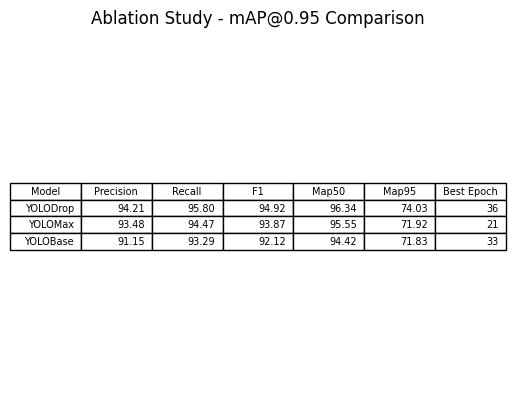

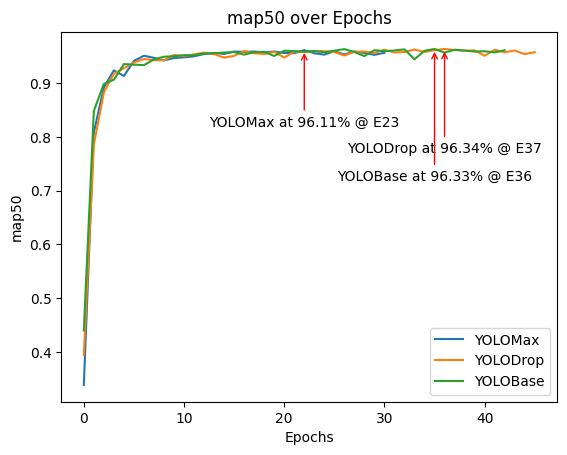

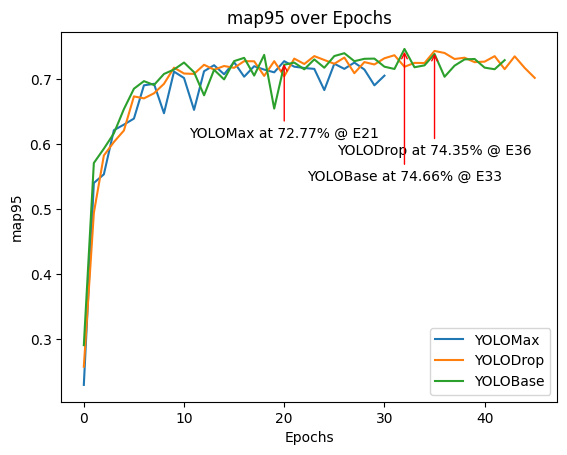

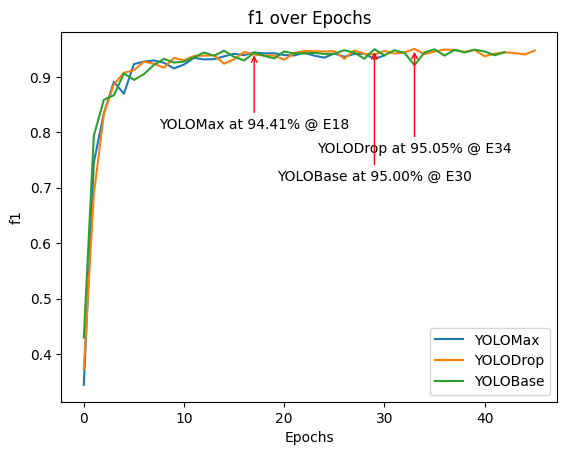

In [13]:
# Show and save charts
ablation_study(data)
show_plot(data, 'map50', -35)
show_plot(data, 'map95', -35)
show_plot(data, 'f1', -35)

In [ ]:
# Run models
for name, model in models.items():
    break
    print(f"Running {name}...")
    if not os.path.exists(f"preds/{name}"):
        os.makedirs(f"preds/{name}")
    for i, image in enumerate(os.listdir("test")):
        result = run_detect(model, f"test/{image}")
        # Save or display the result
        # cv2.imwrite(f"{name}_detection_result.jpg", cv2.cvtColor(np.array(result.permute(1, 2, 0)), cv2.COLOR_RGB2BGR))
    
        pil_image = Image.fromarray(result)
        pil_image.save(f"preds/{name}/detection_result_{i}.png")


In [25]:
# Run models on camera stream simultaneously
import cv2
from multiprocessing import Process, Queue
import torch
import torchvision.transforms.v2 as v2
import numpy as np
from multiprocessing import set_start_method
set_start_method('spawn', force=True)  # For CUDA compatibility
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transforms = v2.Compose([ 
    v2.ToImage(),
    v2.Resize((640, 640)),
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=mean, std=std),
])

font = None
import matplotlib.font_manager as fm
for font in fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/']):
    if 'Serif-Regular' in font:
        font = font
        break

def worker(in_queue, out_queue, model):
    """Manages the worker pool."""
        
    model.to(device)
    model.eval()
    while True:
        frame = in_queue.get()
        if frame is None:
            break
        annotated_frame = detect_stream(model, frame, transforms, font)
        out_queue.put(annotated_frame)

# in_queues = [Queue(maxsize=1) for _ in models.items()] # One queue per model
# out_queue = Queue()
# processes = []

# for i, (name, model) in enumerate(models.items()):
#     p = Process(target=worker, 
#                 args=(in_queues[i], out_queue, model))
#     processes.append(p)
#     p.start()

# --- 3. Main Video Loop ---
cap = cv2.VideoCapture(1) # Use webcam or a video file

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.imshow('Input', cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    continue
    # 4. Distribute the frame to all worker processes.
    # If an input queue is full, this will block, naturally syncing the frame rate.
    for q in in_queues:
        q.put(frame)

    # 5. Collect the annotated frames from the output queue.
    results = {}
    for _ in models.items():
        res = out_queue.get()
        results[res['model_name']] = res['frame']

    # 6. Assemble the grid for display (e.g., a 2x2 grid for 4 models).
    top_row = np.hstack([results['YOLOBase'], results['YOLOMax'], results['YOLODrop']])
    bottom_row = np.hstack([results['YOLO-P2'], results['YOLOCBAM'], results['YOLOHD']])
    grid_view = np.vstack([top_row, bottom_row])
    cv2.imshow('Concurrent YOLO Models', grid_view)


[ WARN:0@6711.608] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video1): can't open camera by index
[ERROR:0@6711.608] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range
